# Preprocessing/EDA for Small area income estimates for middle layer super output areas, England & Wales, 2011/12

Dataset link: https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales

1.1 **Loading the dataset** from an .xlsx file to a Pandas DataFrame, then displaying the name of the sheets that have relevant information (i.e. variables/potential features)

In [7]:
import pandas as pd

# Defining the path for the raw and processed MSOA Income Estimate data
file_path = "../../data/raw/msoa_income.xlsx"
processed_path = "../../data/processed/" 

# Retrieving and displaying the sheet names
sheets = pd.ExcelFile(file_path).sheet_names
print("The sheet names/tables for MSOA Income Estimate data:", sheets)

The sheet names/tables for MSOA Income Estimate data: ['Contents', 'Metadata', 'Terms and Conditions', 'Total weekly income', 'Net weekly income', 'Net income before housing costs', 'Net income after housing costs', 'Related Publications']


1.2 **Defining the Sheets 4 to 7 as DataFrames.** The other sheets are irrelevant for the cleaning and analysis processes. Therefore for the **preprocessing stage**, these are the following steps:
- **Skipping the first three rows** to use the relevant column headers.
- **Removing the last row** because it is irrelevant to the values of interest and the context of the research.
- **Standardisation of column headers:** Convert to lowercase, replace the spaces with underscores, and remove the whitespace before and after the string. I'll be removing currency symbols from numerical values so that it does not interfere with the analysis.
- Checking for any **missing values**, though it is doubtful to be any.
- Checking for **duplicates** by using the first column as reference (MSOA Code should be unique for each row).
- Display **descriptive statistics** to have a look for any anomalies or outliers (very high or low values compared to the other categories)
- Fundamental **integrity checks** such as looking for negative numbers.

In [10]:
# Defining the relevant sheets now the names are known
relevant_sheets = ["Total weekly income", "Net weekly income", 
"Net income before housing costs", "Net income after housing costs"]

# Storing processed data by initialising a dictionary
adjust_data = {}

# Processing each relevant sheet
for sheet in relevant_sheets:
    print(f"Processing sheet: {sheet}")

    # Loading the relevant sheets and skipping the first three rows
    msoa_income_data = pd.read_excel(file_path, sheet_name = sheet, header = 4)

    # Removing the last row as it is irrelevant (i.e. not a numerical value or a category)
    msoa_income_data = msoa_income_data[:-1]

    # Standardising the column names 
    msoa_income_data.columns = (
        msoa_income_data.columns
        .str.strip() # Ensuring that the space before and after the strings do not affect analysis
        .str.lower() # Coverting the strings to lowercase
        .str.replace(" ", "_") # Replacing the spaces in between words with underscores
        .str.replace("£", "", regex = False) # Removing any currency symbols from numerical values
    )

    # Looking for any duplicates using the 'msoa_code' as this should be unique to each row
    duplicate_rows = msoa_income_data[msoa_income_data.duplicated(subset = ["msoa_code"])]
    if not duplicate_rows.empty:
        print(f"The duplicate rows found in {sheet}:")
        print(duplicate_rows)
        print("-" * 60)
    else:
        print("There are no duplicate rows in {sheet}.")
    
    # Checking for any missing values in the dataset
    print(f"The missing values in {sheet}:")
    print(msoa_income_data.isnull().sum())
    print("-" * 60)

    # Converting data types - income and limits to numeric data types
    # In other words, changing the values where variable names contain the word 'limit' or 'income'.
    cols_numeric = [col for col in msoa_income_data.columns if "income" in col or "limit" in col]
    msoa_income_data[cols_numeric] = msoa_income_data[cols_numeric].apply(pd.to_numeric, errors = "coerce")

    # Identifying anomalies/outliers through some descriptive statisitics 
    print(f"These are the descriptive statistics for {sheet}:")
    print(msoa_income_data[cols_numeric].describe())
    print("-" * 60)

    # Some basic integrity checks such as negative or invalid values (the incomes should not be negative)
    income_invalid = msoa_income_data[cols_numeric].lt(0).any(axis = 1)
    if income_invalid.any():
        print(f"The invalid incomes values found in {sheet}:")
        print(msoa_income_data[income_invalid])
    else:
        print(f"No invalid income values in {sheet}")

    adjust_data[sheet] = msoa_income_data

Processing sheet: Total weekly income
There are no duplicate rows in {sheet}.
The missing values in Total weekly income:
msoa_code                    0
msoa_name                    0
local_authority_code         0
local_authority_name         0
region_code                  0
region_name                  0
total_weekly_income_()       0
upper_confidence_limit_()    0
lower_confidence_limit_()    0
confidence_interval_()       0
dtype: int64
------------------------------------------------------------
These are the descriptive statistics for Total weekly income:
       total_weekly_income_()  upper_confidence_limit_()  \
count             7201.000000                7201.000000   
mean               731.353979                 801.719206   
std                190.048422                 208.079284   
min                300.000000                 340.000000   
25%                590.000000                 650.000000   
50%                710.000000                 770.000000   
75%          

There are **no missing values or invalid income values**, which was expected. There are also **no duplicates** in terms of MSOA codes. 

1.4 I have to decide which sheet is more appropriate for analysis. In this dataset, we have confidence limits and incomes for the following categories, in order of the sheets shown above:
- Total Weekly Income 
- Net Weekly Income
- Net Income before Housing Costs
- Net Income after Housing Costs

Given the descriptive statistics for each dataset sheet **(specifically focusing on the incomes)**:
- Total Weekly Income is **significantly higher** in terms of **mean, std, 25%, 50%, 75%**, and **max** values.
- Net Weekly Income and Net Income before Housing Costs are **very close** in terms of **mean, 25%, 50%,** and **max** values.
- Net Weekly Income, Net Income before Housing Costs, and Net Income after Housing Costs are **very close** in terms of **std** values.
- Net Income after **Housing Costs** is **significantly lower** in terms of **min** values
- Net Weekly Income, Net Income before Housing Costs, and Total Weekly Income are **very close** in terms of **min** values.

This means that:
- The higher values shown from the **Total Weekly Income** suggest that it is **undesirable** because it does not consider any deductions (i.e. taxes, housing costs). Therefore, it does not reflect the financial reality of households.
- **Net Weekly Income** and **Net Income before Housing Costs** do not include deductions for the housing costs, which is especially important if your income is at the lower end of the spectrum (see the research below). Also, their values are very similar, to the extent that having both of them would be somewhat redundant.
- The significantly lower minimum values of **Net Income after Income** suggest that housing costs may be very high for some people, and in terms of machine learning techniques, there is more variation regarding target variables. This is good because it can reduce the chances of overfitting. Therefore, this sheet is **more desirable** to use as it pertains to the financial reality of households.

#### Below is some research on the best category to choose:

According to this commentary on the following graph that investigates the relationship between income and life expectancy using MSOA  (https://www.health.org.uk/evidence-hub/money-and-resources/income/relationship-between-income-and-healthy-life-expectancy-by-neighbourhood):
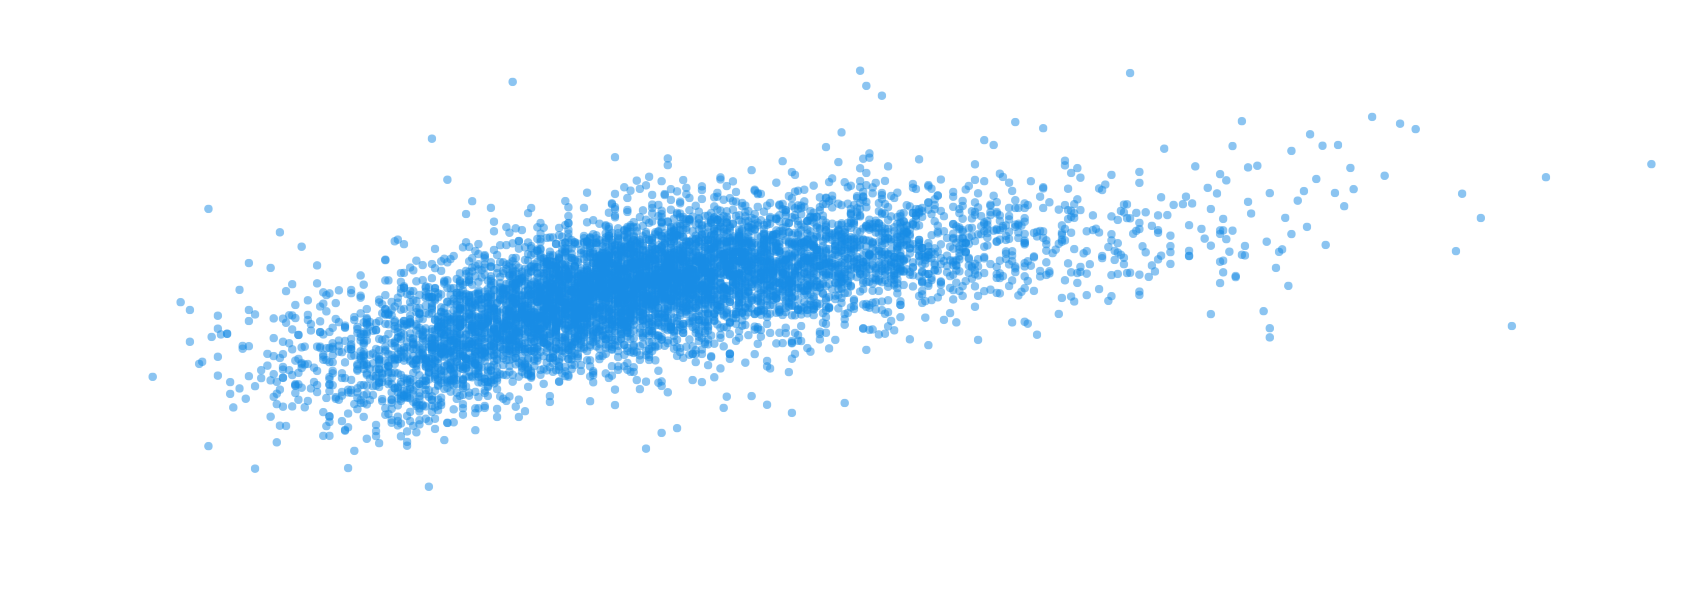
- Source: Health Foundation analysis of Office for National Statistics, Income Estimates for Small Areas, England & Wales, 2019/2020, Life expectancy at birth and age 65 by sex for Middle layer Super Output Areas (MSOAs), England: 2016 to 2020

They mention that the most accurate measurement to show the available resources would be the **Household Income after Housing Costs**. For example, those who are categorised within lower-income households would see a larger proportion of their income taken to pay for their domestic bills.  


#### Final Decision on MSOA Income Estimation data:
- The last sheet, **Household Income after Housing Costs** will be used for analysis
- The other sheets will be saved, in the scenario that the **generalisation** does not go well. This can be used for **sensitivity analysis, model stress tests** etc.

1.5 **Filter the dataset**, so that I am only focusing on values for the geographical area of London. Then do the steps mentioned above (i.e. Final Decision.....)

In [12]:
# Defining the sheet names; one for analysis and the rest for backup
chosen_sheet = "Net income after housing costs"
other_sheets = ["Total weekly income", "Net weekly income", "Net income before housing costs"]

# Defining a function to filter for only London data
def filtering_for_london(data):
    return data[data['region_name'].str.lower() == 'london']

# Separating the chosen sheet for analysis
chosen_data = adjust_data[chosen_sheet]
print(f"Processing the data for {chosen_sheet}")

# Filtering for only the London data
filtered_chosen_data = filtering_for_london(chosen_data)
print(f"Successfully filtered {chosen_sheet} for London data")

# Saving the chosen sheet after filtering for London data
chosen_file_name = f"{processed_path}msoa_income_{chosen_sheet.replace(' ', '_').lower()}.csv"
filtered_chosen_data.to_csv(chosen_file_name, index = False)
print(f"{chosen_file_name} has been saved successfully. \n")

# Separating the remaining sheets for backup
for sheet in other_sheets:
    msoa_income_data = adjust_data[sheet]
    print(f"Processing the data for {sheet}")

    # Filtering for only London data
    filtered_msoa_data = filtering_for_london(msoa_income_data)
    print(f"Successfully filtered {chosen_sheet} for London data")

    # Saving each backup sheet after filtering for London
    backup_file_name = f"{processed_path}backup_msoa_income_{sheet.replace(' ', '_').lower()}.csv"
    filtered_msoa_data.to_csv(backup_file_name, index = False)
    print(f"{backup_file_name} has been saved successfully. \n")

Processing the data for Net income after housing costs
Successfully filtered Net income after housing costs for London data
../../data/processed/msoa_income_net_income_after_housing_costs.csv has been saved successfully. 

Processing the data for Total weekly income
Successfully filtered Net income after housing costs for London data
../../data/processed/backup_msoa_income_total_weekly_income.csv has been saved successfully. 

Processing the data for Net weekly income
Successfully filtered Net income after housing costs for London data
../../data/processed/backup_msoa_income_net_weekly_income.csv has been saved successfully. 

Processing the data for Net income before housing costs
Successfully filtered Net income after housing costs for London data
../../data/processed/backup_msoa_income_net_income_before_housing_costs.csv has been saved successfully. 



The backup data and the chosen data were separated, filtered and stored successfully. Therefore, I can move on to preprocessing the LSOA Crime data. 

## The Preprocessing/EDA of LSOA crime data by the London Metropolitan Police

Data source: https://data.london.gov.uk/dataset/recorded_crime_summary

I was going to use this data for analysis, but I realised that the LSOA Census Data has the same data. I have compared the values of their respective features, and they match, but a few have small differences. I think the London Metropolitan Police source is more accurate. However, the differences are very small, and due to some of the other limitations in the analysis, it would be feasible to omit this dataset. Therefore, I'll leave this in my final notebook, just in case it is needed for further analysis. 

# The Preprocessing/EDA of LSOA atlas data by the Greater London Authority
Contains census data for LSOA boundaries in 2011. Some of the data is indicative to show trends and not the official ONS statistics. This is because of the merging of certain areas. 

Dataset source: https://data.london.gov.uk/dataset/lsoa-atlas

1.1 Loading the dataset from an .xlsx file to a Pandas DataFrame, then displaying the name of the sheets that have relevant information (i.e. variables/potential features)

In [37]:
import pandas as pd

# Loading the Excel file for LSOA atlas data, which I will name "lsoa_census_data" from now on.
file_path = "../../data/raw/lsoa_census.xlsx"

# Retrieving and displaying the sheet names
sheets = pd.ExcelFile(file_path).sheet_names
print("The sheet names/tables for MSOA Income Estimate data:", sheets)

The sheet names/tables for MSOA Income Estimate data: ['iadatasheet1', 'iadatasheet2', 'iadatasheet3', 'iadatasheet4', 'iadatasheet5', 'iadatasheet6', 'Metadata']


1.2 Loading Sheets 1 to 6 as DataFrames. The other sheets are irrelevant for the cleaning and analysis processes.

In [38]:
# Loading sheets as DataFrames
relevant_sheets = sheets[0:5]
lsoa_census_data = {sheet: pd.read_excel(file_path, sheet_name = sheet) 
                    for sheet in relevant_sheets}

# Exploring each DataFrame by looping through each sheet
for sheet, census in lsoa_census_data.items():
    print(f"Sheet: {sheet}")
    print(census.head())
    print(census.info())

Sheet: iadatasheet1
  Unnamed: 0           Unnamed: 1 Mid-year Population Estimates  Unnamed: 3  \
0        NaN                  NaN                      All Ages         NaN   
1      Codes                Names                          2001      2002.0   
2  E01000001  City of London 001A                          1615      1571.0   
3  E01000002  City of London 001B                          1493      1452.0   
4  E01000003  City of London 001C                          1573      1547.0   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1      2003.0      2004.0      2005.0      2006.0      2007.0      2008.0   
2      1578.0      1559.0      1461.0      1474.0      1538.0      1504.0   
3      1401.0      1398.0      1402.0      1430.0      1467.0      1417.0   
4      1506.0      1487.0      1536.0      1524.0      1602.0      1499.0   

   ...                       Unnamed: 200 

As you can see from the output above, there are numerous rows of headers that are merged and unmerged. This dataset is complex compared to the lsoa_crime and msoa_income datasets. I need to carefully look at the first 3 rows to understand their order and structures. I need to use human reasoning and manually go through each sheet to decide how I am going to combine these headers into one layer (i.e. three rows of headers into one). 

1.3 Manual Approach to the Handle Multi-level Headers:

In [39]:
# Iterating over each sheet, taking the first three rows to display them.
for sheet, census in lsoa_census_data.items():
    header = census.iloc[:3] 
    print(f"Sheet: {sheet}\n{header}") 

Sheet: iadatasheet1
  Unnamed: 0           Unnamed: 1 Mid-year Population Estimates  Unnamed: 3  \
0        NaN                  NaN                      All Ages         NaN   
1      Codes                Names                          2001      2002.0   
2  E01000001  City of London 001A                          1615      1571.0   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1      2003.0      2004.0      2005.0      2006.0      2007.0      2008.0   
2      1578.0      1559.0      1461.0      1474.0      1538.0      1504.0   

   ...                       Unnamed: 200  Unnamed: 201  Unnamed: 202  \
0  ...  % Dwellings in Council Tax Band H           NaN           NaN   
1  ...                               2005       2006.00       2007.00   
2  ...                               0.57          0.57          0.56   

   Unnamed: 203 Unnamed: 204  Unnamed: 205  Unnamed: 206  Hou

I want to simplify the sheets one by one, as much as I can. So I am going to start with the first sheet until the sixth sheet, listing what I am going to remove:
1. First sheet:
   - Column 3 to 86 - I do not need all the ages for multiple years. I will use the 2011 Census Population which has simplified that category to columns)
   - Column 117 to 125 - 2011 Religion data is not of interest to me. But I will keep Ethnic groups/Country of Birth for now.
   - Column 137 to 151 - Vacant Dwelling/Stock Total is not needed as I am more interested in the Dwelling type (2011).
   - Column 152 to 207 - I do not need Dwelling by Council Tax Data
   - Column 208 to 210 - This is about Sales in House Prices which is highly aggregated and not directly correlated with the levels of income in a given ares.
2. Second sheet:
   - Column 3 to 44 - Crime numbers but keeping the crime rates because they are normalised.
   - Column 103 - I do not think apprenticeships will give clear insights about income levels, and  other there are other interesting categories regarding qualifications and education levels.
   - Column 108 to 124 and 126 to 131 - Workplace Employment is not as insightful as Employment rates. And the Claimant Count for JobSeekers Allowance will be removed except the one for May-11 and May-12.
3. I am removing the whole third sheet, because this is about Pensions etc.
4. Fourth sheet:
   - Column 3 to 72 - Disability Living Allowance, which is not of interest.
   - Column 143 to 168 - 2008/2010 data that is not within the range of interest (i.e. 2011/12)
   - Column 171 to 186 - 2005/2008, same reason as above
   - Column 228 - 251 - Only interested in the total number of children whose parents have claimed benefits for.
5. Fifth sheet:
   - Column 28 to 32 - Free School Meals can be removed except the total amount.
   - Column 34 to 51 - Pupil Absences will be removed except the number for Unauthorised Absence in All Schools and Persistent Absentees in All Schools.
   - Column 64 to 103 - Early Stages and KS1 will be removed for simplification purposes and older children will provide more insights in terms of income levels and educational development. Therefore KS2 and onwards will be used as features.
   - Column 104 to 136 - KS2 will be removed except for Average Point Score of Pupils
   - Column 146 to 181 - GCSE but Average Capped GCSE is more useful to the research, as it disregards additional subjects and focuses on the top 9 performing subjects/grades of students.
   - Column 192 to 203 - A/AS Level removed except for Level 3 QCDA Point Score Per Student.
   - Remove all columns from Column 3 onwards that are not about "2011", "2012" or "2011/12"
6. Remove the whole of the sixth sheet because it is about 2010 data.

A lot of these columns are removed because of multicollinearity purposes and as a preliminary step of cleaning/preprocessing.

In [41]:
# Defining a function that can clean each sheet 
def clean_sheet(lsoa_data, sheet_name):
    if sheet_name == 'iadatasheet1':
        # Dropping the columns by range
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[2:86], errors='ignore')  # Columns 3 to 86
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[116:125], errors='ignore')  # Columns 117 to 125
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[136:210], errors='ignore')  # Columns 137 to 210

    elif sheet_name == 'iadatasheet2':
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[2:44], errors='ignore')  # Columns 3 to 44
        lsoa_data = lsoa_data.drop(columns=[102], errors='ignore')  # Column 103
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[107:124], errors='ignore')  # Columns 108 to 124
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[125:131], errors='ignore')  # Columns 126 to 131

    elif sheet_name == 'iadatasheet3':
        # Removing the entire sheet
        return None

    elif sheet_name == 'iadatasheet4':
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[2:72], errors='ignore')  # Columns 3 to 72
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[142:168], errors='ignore')  # Columns 143 to 168
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[170:186], errors='ignore')  # Columns 171 to 186
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[227:251], errors='ignore')  # Columns 228 to 251, keep total for children

    elif sheet_name == 'iadatasheet5':
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[27:32], errors='ignore')  # Columns 28 to 32
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[33:51], errors='ignore')  # Columns 34 to 51
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[63:103], errors='ignore')  # Columns 64 to 103
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[103:136], errors='ignore')  # Columns 104 to 136
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[145:181], errors='ignore')  # Columns 146 to 181
        lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[191:203], errors='ignore')  # Columns 192 to 203

    elif sheet_name == 'iadatasheet6':
        # Removing the entire sheet
        return None

    # Removing the first column
    lsoa_data = lsoa_data.drop(columns=lsoa_data.columns[0], errors='ignore')
    
    return lsoa_data

# Iterating over sheets and cleaning them
lsoa_cleaned_sheets = {}
for sheet_name, lsoa_data in lsoa_census_data.items():
    lsoa_cleaned_data = clean_sheet(lsoa_data, sheet_name)
    if lsoa_cleaned_data is not None:
        lsoa_cleaned_sheets[sheet_name] = lsoa_cleaned_data

# Saving the cleaned sheets to a new Excel file
output_path = '../../data/processed/lsoa_data_cleaned.xlsx'
with pd.ExcelWriter(output_path) as writer:
    for sheet_name, lsoa_data in lsoa_cleaned_sheets.items():
        lsoa_data.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"The cleaned sheets have been saved to {output_path} successfully")

The cleaned sheets have been saved to ../../data/processed/lsoa_data_cleaned.xlsx successfully


I realise that I need to manually rearrange the columns and headers, for the sake of time. The process will take too long through Python code. 

In [42]:
# Reading the cleaned Excel file and display the first three rows of each sheet
output_path = '../../data/processed/lsoa_data_cleaned.xlsx'

# Loading the cleaned sheets into a dictionary
cleaned_lsoa_data = pd.read_excel(output_path, sheet_name=None)

# Displaying the first three rows for each sheet
for sheet_name, lsoa_data in cleaned_lsoa_data.items():
    print(f"The first three rows of sheet: {sheet_name}")
    print(lsoa_data.head(3))
    print("\n" + "-" * 50 + "\n")

The first three rows of sheet: iadatasheet1
            Unnamed: 1 2011 Census Population Unnamed: 87 Unnamed: 88  \
0                  NaN          Age Structure         NaN         NaN   
1                Names               All Ages        0-15       16-29   
2  City of London 001A                   1465         115         216   

  Unnamed: 89 Unnamed: 90 Unnamed: 91  Unnamed: 92 Population Density (2011)  \
0         NaN         NaN         NaN          NaN       Persons per hectare   
1       30-44       45-64         65+  Working-age                       NaN   
2         379         487         268         1082                112.865948   

  Households (2011)  ...                       Unnamed: 191  \
0    All households  ...  % Dwellings in Council Tax Band F   
1               NaN  ...                               2010   
2               876  ...                              13.81   

                        Unnamed: 192                       Unnamed: 193  \
0  % Dwellings

This is looking better, but I will fill in the rest of the column headers in MS Excel and make sure leave the headers in a single row.

In [60]:
# Reading the cleaned Excel file and display the first three rows of each sheet
output_path = '../../data/processed/lsoa_data_cleaned.xlsx'

# Loading the cleaned sheets into a dictionary
cleaned_lsoa_data = pd.read_excel(output_path, sheet_name=None)

# Displaying the first three rows for each sheet
for sheet_name, lsoa_data in cleaned_lsoa_data.items():
    print(f"The first three rows of sheet: {sheet_name}")
    print(lsoa_data.head(3))
    print("\n" + "-" * 50 + "\n")

The first three rows of sheet: iadatasheet1
   lsoa_code                names  all_ages_count_2011  \
0  E01000001  City of London 001A               1465.0   
1  E01000002  City of London 001B               1436.0   
2  E01000003  City of London 001C               1346.0   

   ages_65_plus_count_2011  working_age_count_2011  persons_per_hectare_2011  \
0                    268.0                  1082.0                112.865948   
1                    269.0                  1024.0                 62.872154   
2                    254.0                   988.0                227.749577   

   couples_with_children_percent_2011  couples_without_children_percent_2011  \
0                            7.648402                              24.771689   
1                           10.361446                              26.024096   
2                            6.242350                              16.156671   

   lone_parent_household_percent_2011  race_white_count_2011  ...  \
0           

This is what I refined:
- The first three rows are now consolidated into a single layer of relevant columns names
- Irrelevant years were removed, except 2011 and 2012 data.
- I changed the column names into lowercase and replaced the spaces between words with underscores.
- I extracted the metrics that are relevant to the research questions and project goals (i.e. crime, housing, education and employment rates for income estimates)

1.3 Missing Values, Data Types, Unit Consistency, and Data Integrity
- Firstly, I will merge the sheets in the refined dataset.
- Then inspect for data types, duplicates, non-numerical values, irrelevant columns etc.

In [61]:
# Updating relevant sheets because some of them have been deleted
relevant_sheets = ['iadatasheet1', 'iadatasheet2', 'iadatasheet4', 'iadatasheet5']

# Merging the DataFrame sheets in lsoa_census_data dictionary
merged_data = cleaned_lsoa_data[relevant_sheets[0]]

for sheet in relevant_sheets[1:]:
    merged_data = merged_data.merge(
        cleaned_lsoa_data[sheet],
        how= 'left',
        on= 'lsoa_code',
        suffixes=('', f'_{sheet}')  # Handling the duplicate column names
    )


# Resolving the duplicate column names 
# Keeping the first occurrence of a column with duplicates
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Validate the merge
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 0 to 4767
Data columns (total 68 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   lsoa_code                                        4765 non-null   object 
 1   names                                            4768 non-null   object 
 2   all_ages_count_2011                              4768 non-null   float64
 3   ages_65_plus_count_2011                          4768 non-null   float64
 4   working_age_count_2011                           4768 non-null   float64
 5   persons_per_hectare_2011                         4768 non-null   float64
 6   couples_with_children_percent_2011               4768 non-null   float64
 7   couples_without_children_percent_2011            4768 non-null   float64
 8   lone_parent_household_percent_2011               4768 non-null   float64
 9   race_white_count_2011         

Row 43 to 60 have the same names but they are quarterly rates that measure how ma, but I renamed them because I planned to aggregate them to represent 2011/12 for simplify the dataset.

In [62]:
# Calculating the annual averages
merged_data['rate_of_people_income_support_2011_avg'] = merged_data[['rate_of_people_income_support_2011', 
                                                           'rate_of_people_income_support_2011.1', 
                                                           'rate_of_people_income_support_2011.2', 
                                                           'rate_of_people_income_support_2011.3']].mean(axis=1)

merged_data['rate_of_people_income_support_2012_avg'] = merged_data[['rate_of_people_income_support_2012', 
                                                           'rate_of_people_income_support_2012.1', 
                                                           'rate_of_people_income_support_2012.2', 
                                                           'rate_of_people_income_support_2012.3']].mean(axis=1)

# Aggregating into a single variable
merged_data['rate_of_people_income_support_2011_12'] = merged_data[['rate_of_people_income_support_2011_avg', 
                                                          'rate_of_people_income_support_2012_avg']].mean(axis=1)

# Dropping the original quarterly columns and placeholder columns
columns_to_drop = ['names_iadatasheet2', 'names_iadatasheet4', 'names_iadatasheet5', 
                   'rate_of_people_income_support_2011.1', 'rate_of_people_income_support_2011.2', 
                   'rate_of_people_income_support_2011.3', 'rate_of_people_income_support_2011.1', 
                   'rate_of_people_income_support_2011.2', 'rate_of_people_income_support_2011.3']
merged_data.drop(columns=columns_to_drop, inplace=True)

1.4 KNN Imputation was used instead of Mean or Median imputation, because this methods considers the correlation with other variables and does not negatively affect the variance. Mean and Median relies on central tendency and doesnt adapt well to complex data such as the dataset which I am using. Also, this method is more realistic and is closer to reaching a true representation of data, which usually has some noise or outliers.

In [64]:
# Before I begin KNN Imputing, I need to change some column names to lowercase and correct some mistakes
merged_data.rename(columns={'avg_lvl_3_QCDA_per_student_2011_12': 'avg_lvl_3_qcda_per_student_2011_12'}, inplace=True)
merged_data.rename(columns={'lone_parent_household_percent_2011_iadatasheet2': 'lone_parent_household_percent_2011'}, inplace=True)

In [67]:
from sklearn.impute import KNNImputer
import pandas as pd

# 1. Converting the non-numeric values in numeric columns to NaN
numeric_columns = ['avg_point_ks2_percent_2011', 'avg_point_ks2_percent_2012', 'avg_capped_gcse_points_per_pupil_2011_12', 'avg_lvl_3_qcda_per_student_2011_12']
for col in numeric_columns:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# 2. Handling missing values with KNN imputation
# Select the numeric columns (exclude columns like the target variable if needed)
numeric_columns_for_imputation = merged_data.select_dtypes(include=['float64']).columns

# Initialising KNNImputer (you can adjust n_neighbors based on your data)
knn_imputer = KNNImputer(n_neighbors = 5)

# Applying KNN imputation to the numeric columns
merged_data[numeric_columns_for_imputation] = knn_imputer.fit_transform(merged_data[numeric_columns_for_imputation])

# 3. Converting object columns like 'child_out_of_work_benefit_percent_2011' to numeric (if applicable)
merged_data['child_out_of_work_benefit_percent_2011'] = pd.to_numeric(merged_data['child_out_of_work_benefit_percent_2011'], errors='coerce')

# Checking to see if there are any columns left as objects
object_columns = merged_data.select_dtypes(include=['object']).columns
print(f"Object columns remaining: {object_columns}")

# Checking to see if there are any missing values after imputation
missing_values_after_imputation = merged_data.isnull().sum()
print(f"Missing values after KNN imputation: \n{missing_values_after_imputation}")


Object columns remaining: Index(['lsoa_code', 'names', 'child_tax_credit_lone_parent_percent_2011',
       'child_out_of_work_benefit_percent_2012',
       'persistent_absentees__percent_2011_12'],
      dtype='object')
Missing values after KNN imputation: 
lsoa_code                                   3
names                                       0
all_ages_count_2011                         0
ages_65_plus_count_2011                     0
working_age_count_2011                      0
                                           ..
avg_lvl_3_qcda_per_student_2011_12          0
avg_capped_gcse_points_per_pupil_2011_12    0
rate_of_people_income_support_2011_avg      0
rate_of_people_income_support_2012_avg      0
rate_of_people_income_support_2011_12       0
Length: 65, dtype: int64


There are some missing values in the lsoa_code column. I want to check the bottom of the dataset, as I think there are totals for the other columns except the first column.

In [69]:
# Displaying the last 5 five rows
print(merged_data.tail())

      lsoa_code                    names  all_ages_count_2011  \
4763  E01004764         Westminster 013C          2410.000000   
4764  E01004765         Westminster 013D          2023.000000   
4765        NaN  LSOA average for London          1715.270409   
4766        NaN  LSOA average for London          1715.270409   
4767        NaN  LSOA average for London          1715.270409   

      ages_65_plus_count_2011  working_age_count_2011  \
4763               286.000000             1912.000000   
4764               190.000000             1647.000000   
4765               189.851731             1184.471668   
4766               189.851731             1184.471668   
4767               189.851731             1184.471668   

      persons_per_hectare_2011  couples_with_children_percent_2011  \
4763                 38.808374                            5.133333   
4764                 75.456919                            6.074343   
4765                 94.853380                          

Just as I thought but not exactly, the last three rows are LSOA averages for London. I will delete these lines.

In [71]:
# Removing the last three rows
merged_data = merged_data.iloc[:-3]

# Checking to see if it changed or not
print(merged_data.tail())

      lsoa_code             names  all_ages_count_2011  \
4757  E01004758  Westminster 010D               1270.0   
4758  E01004759  Westminster 010E               1947.5   
4759  E01004760  Westminster 014E               1630.0   
4760  E01004761  Westminster 018D               1945.0   
4761  E01004762  Westminster 011E               2070.0   

      ages_65_plus_count_2011  working_age_count_2011  \
4757                     95.5                   819.5   
4758                    201.0                  1236.0   
4759                    160.0                  1184.0   
4760                    254.0                  1532.0   
4761                    323.0                  1531.0   

      persons_per_hectare_2011  couples_with_children_percent_2011  \
4757                151.100535                           20.020222   
4758                175.925926                           18.316195   
4759                227.019499                            9.208820   
4760                 37.3966

In [79]:
# Checking for missing values in each column
missing_values_per_column = merged_data.isnull().sum()

# Sending it to a csv file
missing_values_per_column.to_csv("../../data/raw/missing_values.csv")

This is what I saw was missing: 
child_out_of_work_benefit_percent_2011	37 missing (float column)
persistent_absentees__percent_2011_12	1072 missing (object column of percentages)

Applying KNN Imputation but I have to convert the object column first.

In [83]:
# Creating a copy of merged_data 
merged_data = merged_data.copy()

# 1. Handling the missing values in 'child_out_of_work_benefit_percent_2011' (float column)
# Convert non-numeric values in this column to NaN
merged_data.loc[:, 'child_out_of_work_benefit_percent_2011'] = pd.to_numeric(merged_data['child_out_of_work_benefit_percent_2011'], errors='coerce')

# Applying KNN imputation to the column
knn_imputer = KNNImputer(n_neighbors = 5)
merged_data.loc[:, ['child_out_of_work_benefit_percent_2011']] = knn_imputer.fit_transform(merged_data[['child_out_of_work_benefit_percent_2011']])

# 2. Handling missing values in 'persistent_absentees__percent_2011_12' (object column)
# First, removing any '%' characters and convert to numeric
merged_data.loc[:, 'persistent_absentees__percent_2011_12'] = merged_data['persistent_absentees__percent_2011_12'].replace('%', '', regex=True)
merged_data.loc[:, 'persistent_absentees__percent_2011_12'] = pd.to_numeric(merged_data['persistent_absentees__percent_2011_12'], errors='coerce')

# Applying KNN imputation to the column
merged_data.loc[:, ['persistent_absentees__percent_2011_12']] = knn_imputer.fit_transform(merged_data[['persistent_absentees__percent_2011_12']])

# 3. Checking for missing values after imputation
# Checking missing values only for the specified columns
columns_of_interest = ['child_out_of_work_benefit_percent_2011', 'persistent_absentees__percent_2011_12']
missing_values_for_selected_columns = merged_data[columns_of_interest].isnull().sum()

print(f"Missing values for selected columns: \n{missing_values_for_selected_columns}")


Missing values for selected columns: 
child_out_of_work_benefit_percent_2011    0
persistent_absentees__percent_2011_12     0
dtype: int64


Before Feature Engineering, I am going to change two columns that are objects, to a float column.

In [85]:
# Converting 'child_tax_credit_lone_parent_percent_2011' and 'child_out_of_work_benefit_percent_2012' to float
merged_data['child_tax_credit_lone_parent_percent_2011'] = pd.to_numeric(merged_data['child_tax_credit_lone_parent_percent_2011'], errors='coerce')
merged_data['child_out_of_work_benefit_percent_2012'] = pd.to_numeric(merged_data['child_out_of_work_benefit_percent_2012'], errors='coerce')

In [86]:
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4762 entries, 0 to 4761
Data columns (total 65 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   lsoa_code                                     4762 non-null   object 
 1   names                                         4762 non-null   object 
 2   all_ages_count_2011                           4762 non-null   float64
 3   ages_65_plus_count_2011                       4762 non-null   float64
 4   working_age_count_2011                        4762 non-null   float64
 5   persons_per_hectare_2011                      4762 non-null   float64
 6   couples_with_children_percent_2011            4762 non-null   float64
 7   couples_without_children_percent_2011         4762 non-null   float64
 8   lone_parent_household_percent_2011            4762 non-null   float64
 9   race_white_count_2011                         4762 non-null   f

So all the columns are float columns except the first two columns, which is fine. I will save the lsoa_census data (i.e. merged_data) in the processed data folder.

In [87]:
# Saving the lsoa_census (merged_data) to the processed folder
lsoa_census_path = '../../data/processed/lsoa_census.csv'
merged_data.to_csv(lsoa_census_path, index=False)

## Merging two datasets into one dataset before feature engineering 

1. Merge the lsoa_census data with the msoa_income_net_income_after_housing_costs.csv'

The primary key to linking both datasets is the names (lsoa) and the msoa_names. The prefixes of those columns match but some of the MSOAs and LSOAs do not match due to many boundary rearrangements at the end of 2011. Therefore, I made a separate csv.file extract the rows that do not match, and I will inspect them individually with the website https://findthatpostcode.uk/. This website gives me the active and inactive MSOAs and LSOAs. Also, some of the MSOAs will have LSOAs that have the same income values because certain MSOAs were split into two. Some MSOAs will have LSOAs who have the average values of two MSOAs that consolidated at 2011. 

In [6]:
# Loading the data
msoa_income_path = '../../data/processed/msoa_income_net_income_after_housing_costs.csv'
msoa_income_data = pd.read_csv(msoa_income_path)

# Extract the prefix from 'names' in the LSOA data
merged_data['msoa_prefix'] = merged_data['names'].str.extract(r'(^.* \d+)')

# Merge based on the prefix
merged_data_with_income = pd.merge(
    merged_data, 
    msoa_income_data, 
    left_on='msoa_prefix', 
    right_on='msoa_name', 
    how='left'
)

# Extracting unmatched rows from the MSOA income data
unmatched_msoa = msoa_income_data[~msoa_income_data['msoa_name'].isin(merged_data['msoa_prefix'].unique())]

# Saving the results
merged_data_path = '../../data/processed/lsoa_census_merged_with_income.csv'
unmatched_msoa_path = '../../data/processed/unmatched_msoa.csv'

# Saving the merged data
merged_data_with_income.to_csv(merged_data_path, index=False)

# Saving the unmatched MSOA data
unmatched_msoa.to_csv(unmatched_msoa_path, index=False)

# Displaying the outputs to check
print("Merged Data Preview:")
print(merged_data_with_income.head())

print("\nUnmatched MSOA Data Preview:")
print(unmatched_msoa.head())

Merged Data Preview:
   lsoa_code                names  all_ages_count_2011  \
0  E01000001  City of London 001A               1465.0   
1  E01000002  City of London 001B               1436.0   
2  E01000003  City of London 001C               1346.0   
3  E01000004  City of London 001D               2143.0   
4  E01000005  City of London 001E                985.0   

   ages_65_plus_count_2011  working_age_count_2011  persons_per_hectare_2011  \
0                    268.0                  1082.0                112.865948   
1                    269.0                  1024.0                 62.872154   
2                    254.0                   988.0                227.749577   
3                    117.0                  1932.0                  9.354402   
4                    127.0                   694.0                 51.951477   

   couples_with_children_percent_2011  couples_without_children_percent_2011  \
0                            7.648402                              24

After going through each unmatched row, the missing values of the merged dataset has been restored in their correct places.

In [8]:
# Reloading the updated dataset
updated_data_path = '../../data/processed/lsoa_census_merged_with_income.csv'
merged_data_with_income = pd.read_csv(updated_data_path)

print("Updated dataset loaded successfully.")

# Checking for missing values
missing_values = merged_data_with_income.isnull().sum()

# Displaying columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Updated dataset loaded successfully.
Columns with missing values:
child_tax_credit_lone_parent_percent_2011    1
child_out_of_work_benefit_percent_2012       1
dtype: int64


In [9]:
from sklearn.impute import KNNImputer

# Creating a KNN imputer instance
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors if needed

# Applying KNN Imputation (excluding non-numeric columns)
numeric_columns = merged_data_with_income.select_dtypes(include=['float64', 'int64']).columns
merged_data_with_income[numeric_columns] = imputer.fit_transform(merged_data_with_income[numeric_columns])

# Displaying completion message
print("KNN imputation completed.")


# Generating the descriptive statistics for numeric columns
summary_stats = merged_data_with_income.describe()

print("Quick Statistical Summary:")
print(summary_stats)

KNN imputation completed.
Quick Statistical Summary:
       all_ages_count_2011  ages_65_plus_count_2011  working_age_count_2011  \
count          4762.000000              4762.000000             4762.000000   
mean           1714.973436               189.850168             1184.058484   
std             325.491626                75.091826              285.467505   
min             623.250000                24.000000              387.750000   
25%            1536.000000               135.000000             1012.000000   
50%            1661.000000               178.000000             1131.500000   
75%            1826.750000               234.000000             1287.750000   
max            6289.000000               599.000000             5023.000000   

       persons_per_hectare_2011  couples_with_children_percent_2011  \
count               4762.000000                         4762.000000   
mean                  94.873933                           18.558813   
std                   

Looking at the statistical summary, I can see that the confidence intervals are consistent with the net income after housing costs. The columns have a minimum value of 0, which could be outliers. I will do more checks in the feature engineering part of my notebook (feature_poc.ipynb).

## Feature Engineering

1. Standardisation

The numerical columns (features) will all be standardised to get ready for regression and classification models. So I am making sure that I only have numerical columns only and that any non-numerical columns (id/categoriees/object datatypes) are left the same. 

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# The path to the updated dataset (the merged dataset)
updated_file_path = '../../data/processed/lsoa_census_merged_with_income.csv'

# Loading the updated dataset
merged_data_with_income = pd.read_csv(updated_file_path)

# Displaying a preview to confirm that the data is loaded correctly
print("Loaded Data Preview:")
print(merged_data_with_income.head())


# Identifying the numerical columns
numerical_cols = merged_data_with_income.select_dtypes(include=['float64', 'int64']).columns

# Initialising the scaler
scaler = StandardScaler()

# Standardising the numerical features
merged_data_with_income[numerical_cols] = scaler.fit_transform(merged_data_with_income[numerical_cols])

# Verifying the transformation
print("Standardized Data (First Few Rows):")
print(merged_data_with_income[numerical_cols].head())

# Saving the standardised data for the next steps
standardized_data_path = '../../data/processed/lsoa_census_standardized.csv'
merged_data_with_income.to_csv(standardized_data_path, index=False)


Loaded Data Preview:
   lsoa_code                      names  all_ages_count_2011  \
0  E01000027  Barking and Dagenham 001A               1709.0   
1  E01000028  Barking and Dagenham 001B               1549.0   
2  E01000029  Barking and Dagenham 001C               1602.0   
3  E01000030  Barking and Dagenham 001D               1915.0   
4  E01000031  Barking and Dagenham 002A               1617.0   

   ages_65_plus_count_2011  working_age_count_2011  persons_per_hectare_2011  \
0                    232.0                  1009.0                 11.590370   
1                    220.0                   913.0                107.719054   
2                    445.0                   869.0                 62.358895   
3                    204.0                  1132.0                 66.887880   
4                    231.0                  1033.0                 19.170124   

   couples_with_children_percent_2011  couples_without_children_percent_2011  \
0                           21.06

2. Feature Selection:
    - Correlation Matrix: I am trying to find the relationships between variables (features) and net income after housing costs. This will show me linearity of the relationships with net income. I also will look at for signs of multicollinearity. 

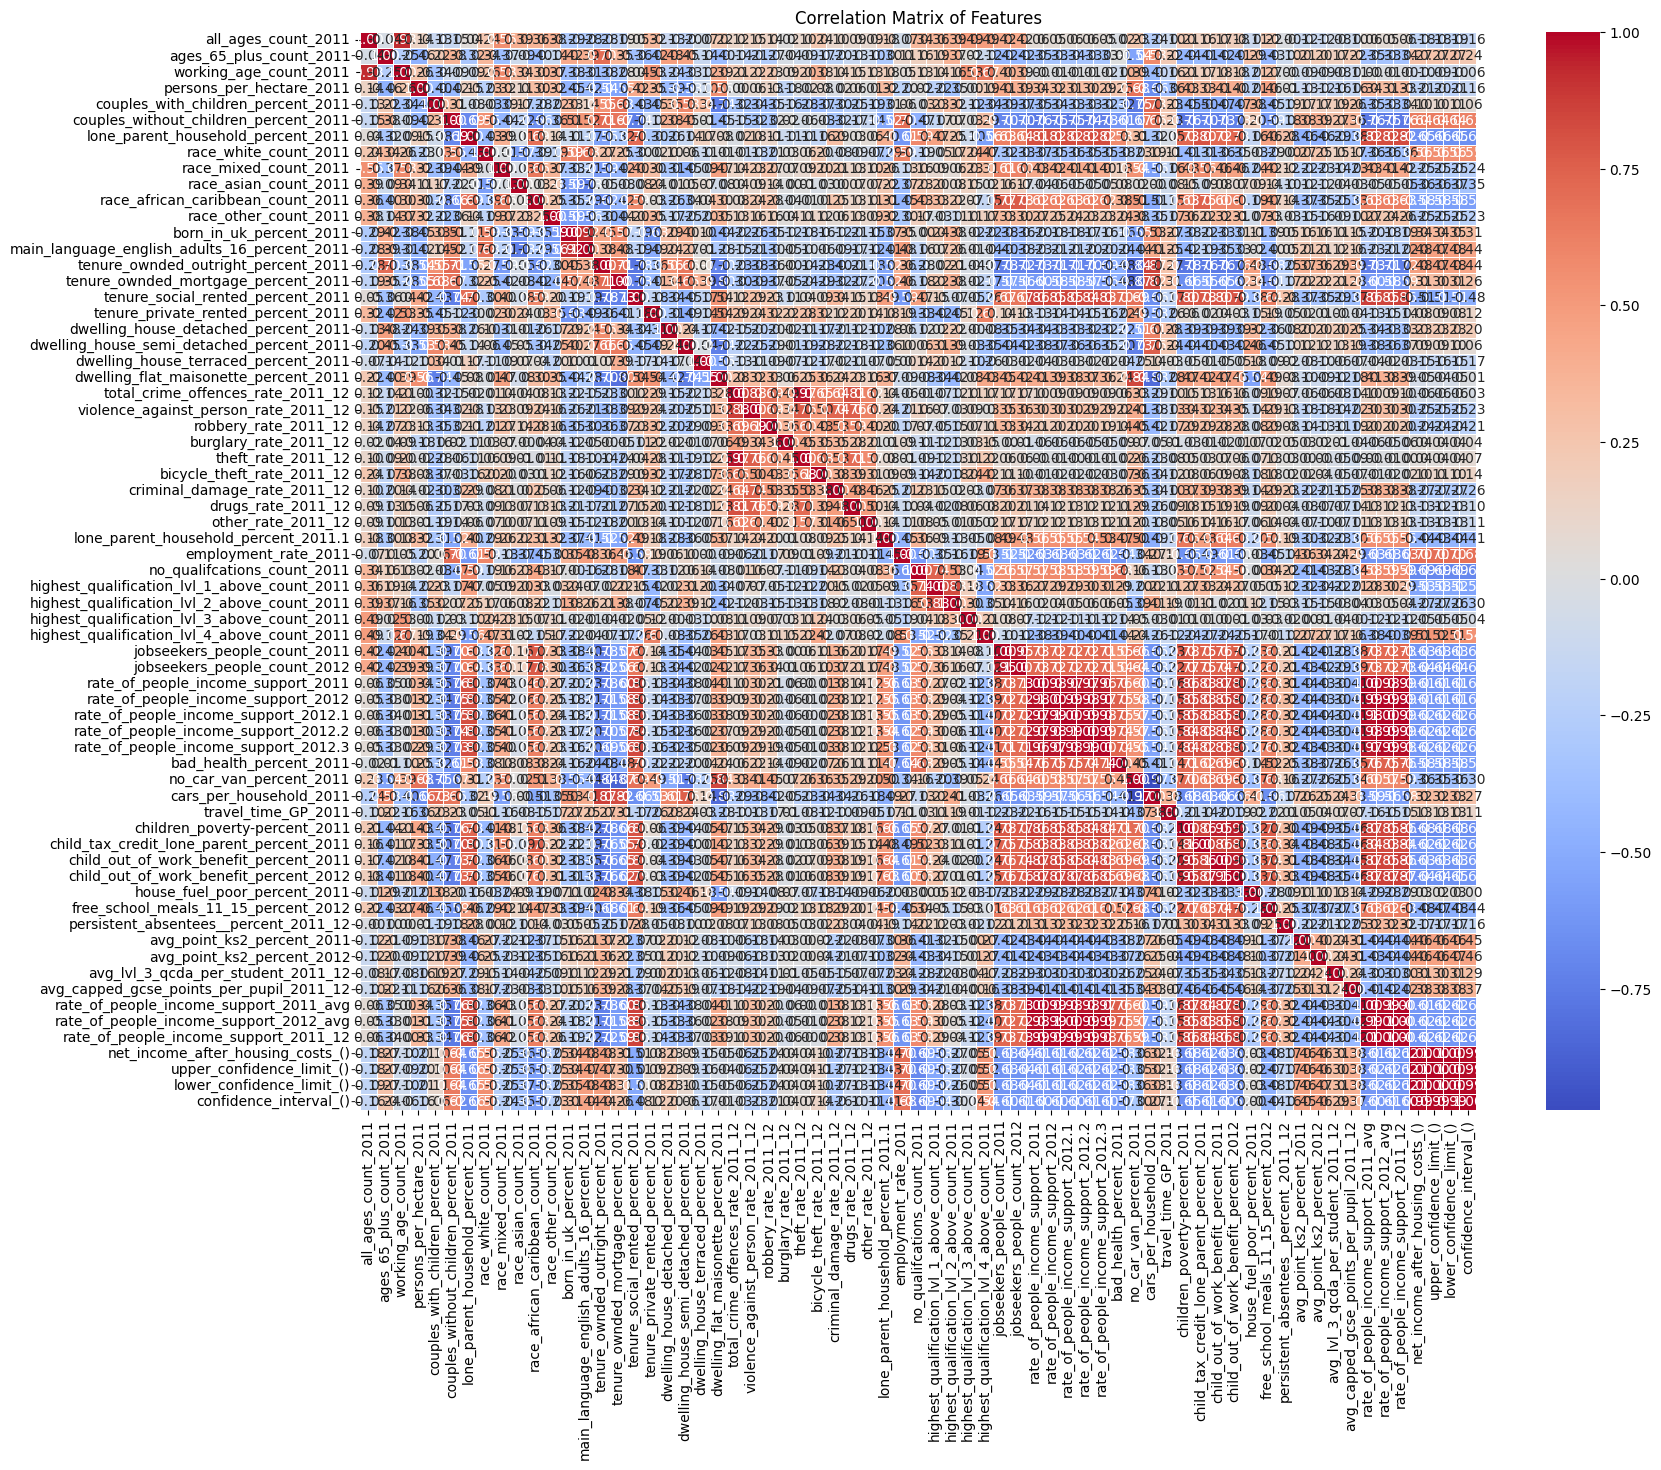

net_income_after_housing_costs_()         1.000000
upper_confidence_limit_()                 0.999435
lower_confidence_limit_()                 0.999247
confidence_interval_()                    0.989209
employment_rate_2011                      0.697535
                                            ...   
jobseekers_people_count_2012             -0.636382
child_out_of_work_benefit_percent_2012   -0.644945
lone_parent_household_percent_2011       -0.653230
children_poverty-percent_2011            -0.678347
no_qualifcations_count_2011              -0.693334
Name: net_income_after_housing_costs_(), Length: 67, dtype: float64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting only the numeric columns
numeric_columns = merged_data_with_income.select_dtypes(include=['number']).columns

# Computing the correlation matrix for the numeric columns
correlation_matrix = merged_data_with_income[numeric_columns].corr()

# Plotting the correlation matrix for all variables (features)
plt.figure(figsize = (18, 14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Focusing on the features that are related to net income
income_related_features = correlation_matrix['net_income_after_housing_costs_()'].sort_values(ascending = False)
print(income_related_features)

# Saving income related correlations to a csv file
income_related_features.to_csv('../../data/raw/income_related_features.csv', header=True)

From the results of the variables which relate to net income. A quick overview would see that the confidence intervals show very high correlations which will likely cause multicollinearity. My estimation based on the analysis so far is that the best features (positive correlation) are:  employment_rate_2011, couples_without_children_percent_2011, race_white_count, highest_qualification_lvl_4_above_count_2011. And the best negative correlations with net income seems to be: no_qualification_count_2011, children_poverty-percent_2011, lone_parent_household_percent_2011, jobseekers_people_count_2011, rate_of_people_income_support_2012_avg, rate_of_people_income_support_2011_12, child_tax_credit_lone_parent_percent_2011, rate_of_people_income_support_2012, and the list goes on.


   - Using Random Forest for Feature Importance:

     Random Forest is an ensemble learning method, and I will use this to assess the importance of various predictors.

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Ensuring the target variable (y) is numeric and drop rows where y has missing values
y = merged_data_with_income['net_income_after_housing_costs_()']
y = pd.to_numeric(y, errors='coerce')
y = y.dropna()

# Selecting only numeric columns for the feature set (X), then dropping rows where X has missing values
numeric_columns = merged_data_with_income.select_dtypes(include = ['number']).columns
X = merged_data_with_income[numeric_columns].drop(columns = ['net_income_after_housing_costs_()'])

# Aligning X and y by dropping rows where any value in X or y is NaN
X = X.loc[y.index]

# Fitting the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Getting the feature importance
feature_importances = pd.DataFrame(rf_model.feature_importances_, 
                                   index = X.columns, 
                                   columns = ["Importance"]).sort_values("Importance", ascending=False)

# Displaying the feature importances
print(feature_importances)
feature_importances.to_csv('../../data/raw/importance_features.csv', header=True)

                                        Importance
lower_confidence_limit_()                 0.697474
upper_confidence_limit_()                 0.301429
confidence_interval_()                    0.000309
born_in_uk_percent_2011                   0.000033
race_asian_count_2011                     0.000032
...                                            ...
rate_of_people_income_support_2011_12     0.000004
rate_of_people_income_support_2011        0.000004
rate_of_people_income_support_2012.1      0.000004
rate_of_people_income_support_2012_avg    0.000004
rate_of_people_income_support_2012        0.000003

[66 rows x 1 columns]


There are many features that show very low importance values, therefore, I will set a threshold to try and simplify the model. I may have to play around with the hyperparameters such as max_depthm min_samples_leaf.

In [16]:
# Setting a threshold for feature importance
threshold = 1e-5
important_features = feature_importances[feature_importances['Importance'] > threshold].index

# Filtering the dataset to include only important features
X_important = X[important_features]

# Re-train the model with only the selected features
rf_model.fit(X_important, y)

# Displaying the updated feature importances
print(rf_model.feature_importances_)

[6.97245782e-01 3.01606234e-01 3.68833217e-04 4.08744079e-05
 4.00342019e-05 3.14775611e-05 3.20749612e-05 2.57652157e-05
 2.41927343e-05 2.45609218e-05 2.12252011e-05 2.31141399e-05
 2.23087599e-05 2.23551233e-05 1.89896436e-05 2.08637614e-05
 2.08408329e-05 2.04008411e-05 1.77504369e-05 2.00239389e-05
 1.86656399e-05 1.71573863e-05 1.97793782e-05 1.93961361e-05
 1.67090486e-05 1.52610572e-05 1.46569872e-05 1.55201064e-05
 1.43264103e-05 1.62918033e-05 1.55689509e-05 1.52164484e-05
 1.49063515e-05 1.60732853e-05 1.69228173e-05 1.56845419e-05
 1.80639327e-05 1.55005376e-05 1.32208105e-05 1.60100782e-05
 1.37949390e-05 1.35721506e-05]


In [ ]:
Retrain it again to see if there are stronger values.

In [17]:
# Defining the threshold for feature importance (e.g., 0.0001)
threshold = 1e-5

# Selecting features with an importance greater than the threshold
important_features = [feature for feature, importance in zip(X.columns, rf_model.feature_importances_) if importance > threshold]

# Filtering the dataset to include only important features
X_important = X[important_features]

# Retraining the model with the selected features
rf_model.fit(X_important, y)

# Evaluating the model's performance again after feature selection
y_pred = rf_model.predict(X_important)
print("Model R^2:", rf_model.score(X_important, y))

Model R^2: 0.9699265907809371


That is a very high score for R^2, which shows that the model explain most of the variance. However, it may be overfitting, so I want to check through cross validation and then tune the hyperparameters. 

In [18]:
from sklearn.model_selection import cross_val_score

# Performing cross-validation to check for overfitting
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')  # 5-fold cross-validation
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R² score from cross-validation: {cv_scores.mean()}")


Cross-validation R² scores: [0.99852045 0.99833546 0.99842588 0.99874294 0.99662056]
Mean R² score from cross-validation: 0.9981290588773529


The results above suggest that the model is generalising well. 

I'm going to use the GridSearchCV function to tune the hyperparamaters. 

In [19]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv = 5,  # 5-fold cross-validation
                           scoring = 'r2',  # Evaluating by R² score
                           n_jobs = -1,  # Using all CPU cores
                           verbose = 2)

# Fitting the grid search
grid_search.fit(X, y)

# Getting the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation R² score: {best_score}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation R² score: 0.9981476819056905


The results of the GridSearchCV was the following: The best parameters was max_depth to 10 levels

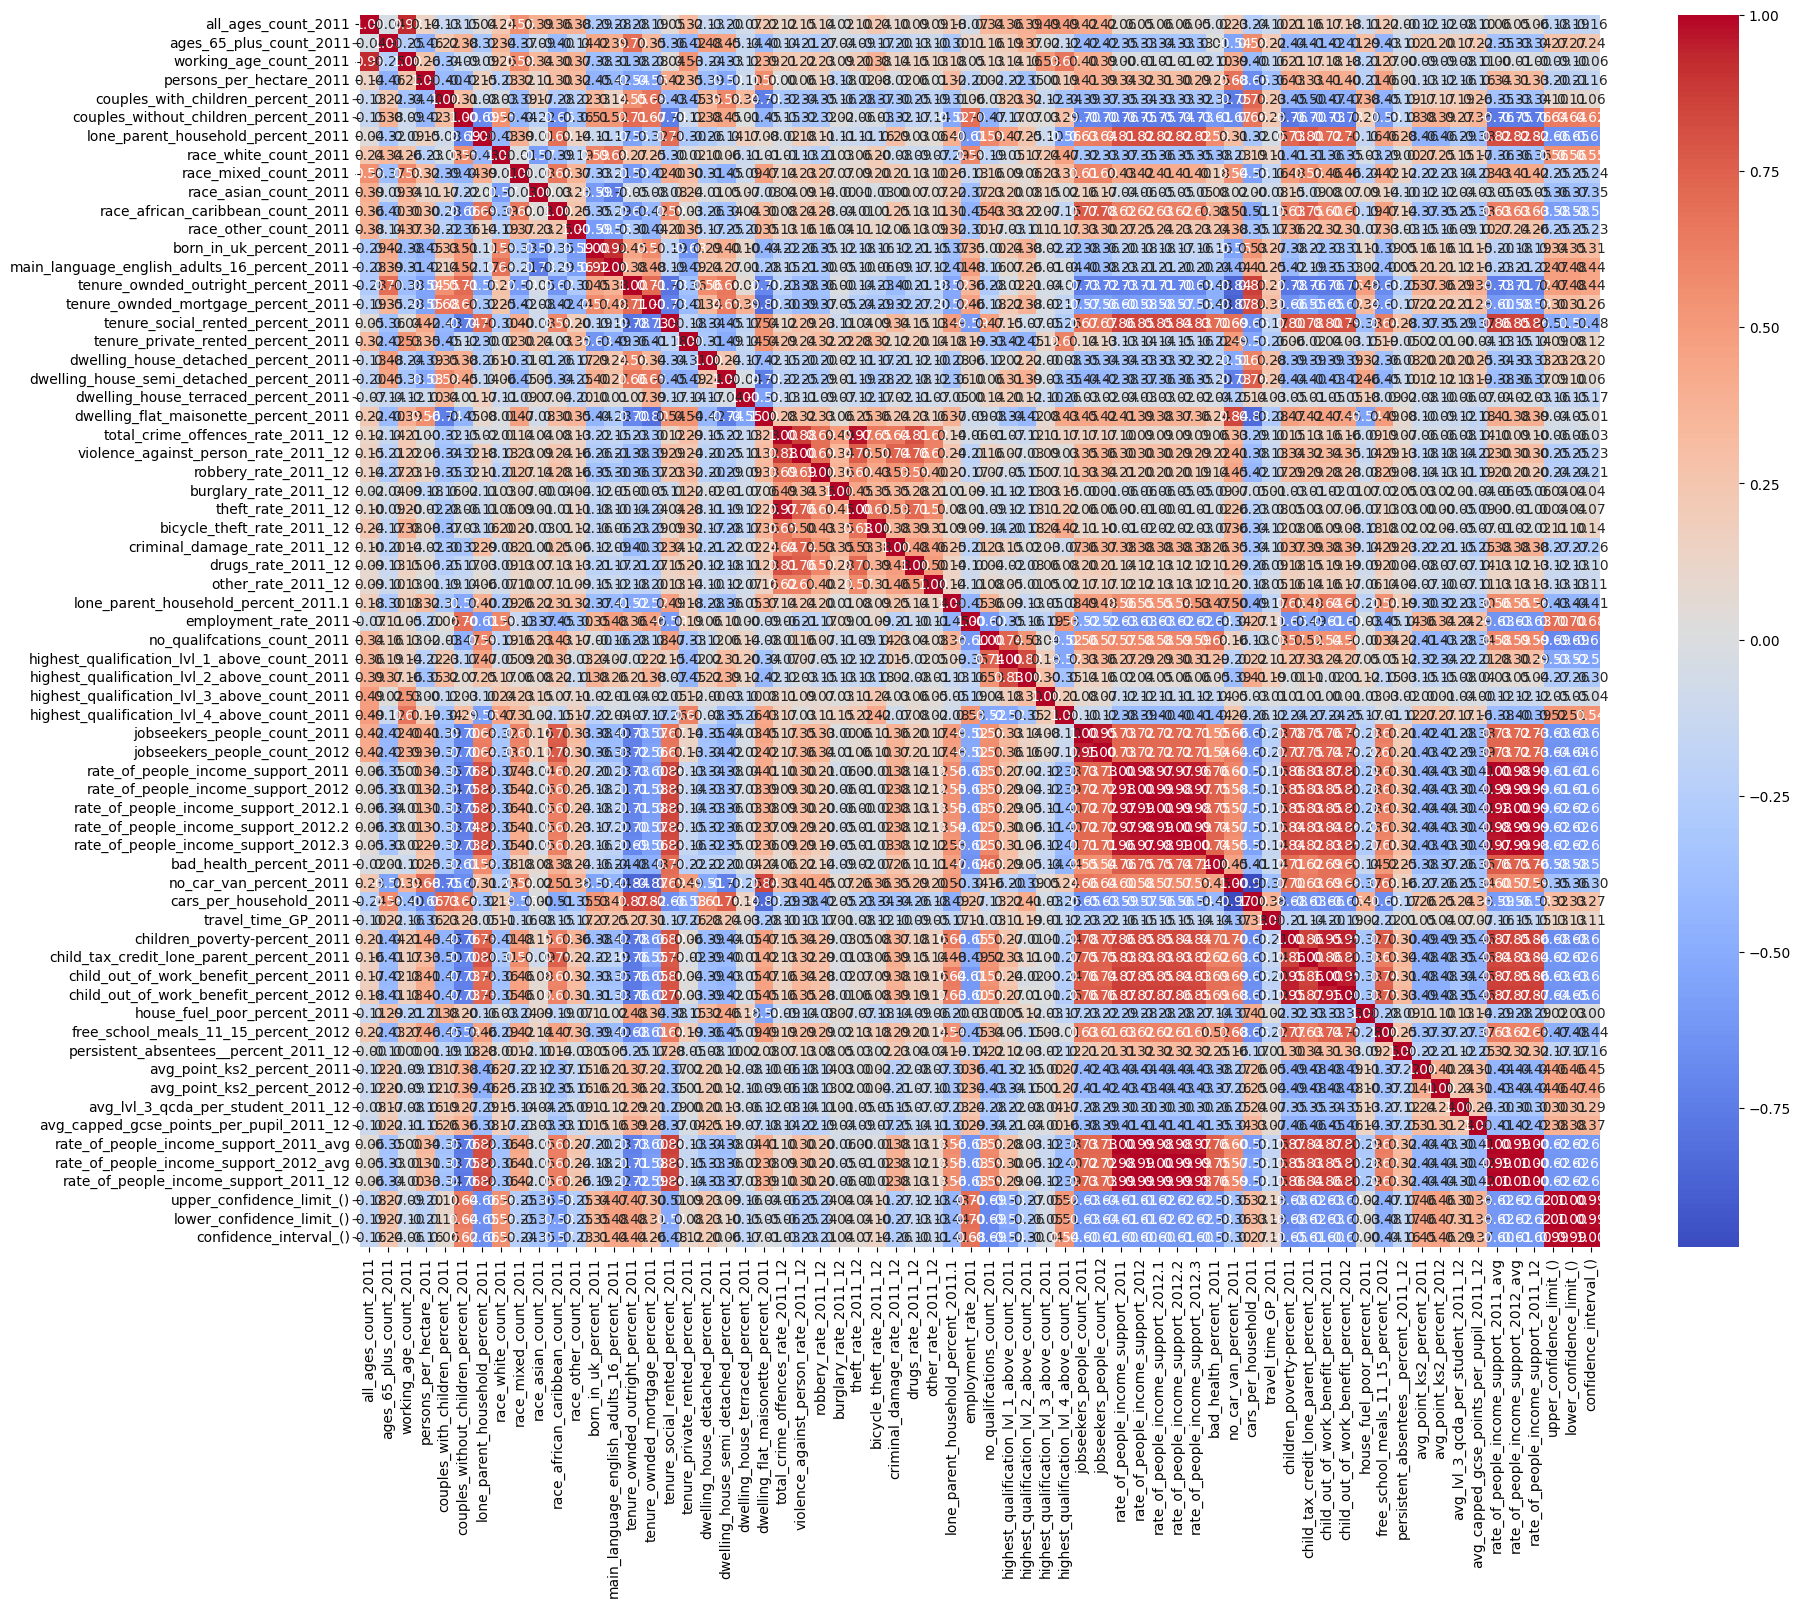

In [24]:
# Computing the correlation matrix
corr_matrix = X.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Personally, I think I have too many features. The RF model was performing very well and it was not overfitting and was actually generalising well. However I would like to experiement with 

In [28]:
threshold = 0.001  # Increase the threshold to keep only the most important features
important_features = [feature for feature, importance in zip(X.columns, rf_model.feature_importances_) if importance > threshold]

# Filter the dataset to include only important features
X_important = X[important_features]

# Re-train the model with the selected features
rf_model.fit(X_important, y)

# Evaluate the model's performance again after feature selection
y_pred = rf_model.predict(X_important)
print("Model R^2:", rf_model.score(X_important, y))

Model R^2: 0.9699265907809371


In [29]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Identify highly correlated features (correlation > 0.9)
corr_threshold = 0.9
highly_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            highly_corr_features.add(colname)

# Drop the highly correlated features
X_reduced = X.drop(columns=highly_corr_features)

# Re-train the model with the reduced feature set
rf_model.fit(X_reduced, y)

# Evaluate the model's performance
y_pred = rf_model.predict(X_reduced)
print("Model R^2:", rf_model.score(X_reduced, y))

Model R^2: 0.9998903975919191


In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Perform cross-validation with the existing RandomForestRegressor model
cv_scores = cross_val_score(rf_model, X_important, y, cv=5, scoring='r2')  # 5-fold cross-validation

# Output cross-validation results
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R² score from cross-validation: {cv_scores.mean()}")

Cross-validation R² scores: [0.74881451 0.69703875 0.75690217 0.78653271 0.72755194]
Mean R² score from cross-validation: 0.7433680172070624
